results are wrong

In [38]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
def source1(no_of_users)->np.ndarray:
    rnd_seed=16
    np.random.seed(rnd_seed)
    return np.random.uniform(-1, 1, (no_of_users))
    # return np.array([0.1, 0.1, 0.1, 0.1, 0.1])

Changed bi

In [40]:
plotting=0
comments=0

no_of_sources=7
no_of_slots=2
threshold_prob=0.9999
threshold_prob_range= np.linspace(0.1, 0.99,100)
snr=15
snr_range=np.arange(0,snr+1)
available_power=0.1
slots_range=np.arange(1,no_of_slots+1)

iterations=100

In [41]:
def pre_process1(msg: np.ndarray, cha_coeff: np.ndarray,alpha:float) -> np.ndarray:
    b = 1/ (cha_coeff) # Standard preprocessing
    # b=1
    return msg * b

def pre_process2(msg: np.ndarray, cha_coeff: np.ndarray,alpha:float) -> np.ndarray:
    b = alpha / (cha_coeff) # Standard preprocessing
    # b=1
    return msg * b


instead of ∑x_i b_i h_i + n  changed to  ∑x_i b_i h_i + n_i

In [42]:
def awgn_mac_with_channel_coeff(symbols, snr_db,channel_coeff)->np.ndarray:
    
    faded_symbols=symbols*channel_coeff# This corresponds to y = x_i * h_i
    
    if(comments):
        print("\t\txb=",symbols)
        print("\t\th=",channel_coeff)
        print("\t\txbh=",faded_symbols,np.sum(faded_symbols))
        pass
    
    signal_power = np.mean(np.abs(symbols) ** 2)   # Signal power calculation
    snr_linear = 10**(snr_db / 10.0)
    noise_variance = signal_power / (snr_linear)
    noise =np.sqrt(noise_variance) * np.random.randn(*faded_symbols.shape)# Noise generation
    
    combined_faded_symbols =np.sum(faded_symbols) + np.sum(noise)
    # noise=0
    
    if(comments):
        print("\t\t∑xbh=",combined_faded_symbols)
        print("\t\tn=",noise)
        pass
    return combined_faded_symbols,noise_variance

changed bi

In [43]:
def demod1(received_signal,cha_coeff,power:float,alpha:float,noise_variance:float)->np.ndarray:
    if(comments):
        print("\t\tr'=",received_signal)
        pass
    alpha=1
    b=np.minimum(alpha /(cha_coeff),np.sqrt(power)/(alpha))
    a_opt=( np.sum(b*cha_coeff) )   /  ( (np.sum((b*cha_coeff)**2)) + (noise_variance) )
    # a_opt=1
    return received_signal*a_opt

def demod2(received_signal,cha_coeff,power:float,alpha:float,noise_variance:float)->np.ndarray:
    if(comments):
        print("\t\tr'=",received_signal)
        pass
    b=alpha*np.minimum(1 /(abs(cha_coeff)),(alpha)/np.sqrt(power))
    a_opt=( np.sum(b*cha_coeff) )   /  ( (np.sum((b*cha_coeff)**2)) + (noise_variance) )
    # a_opt=1
    return received_signal*a_opt

input parmaeters

In [44]:
mse = []
for snr in snr_range: 
    alpha=np.sqrt( 2* np.log(  (1/ (1-(1-threshold_prob )**(1/no_of_slots))  )  ) )
    channel_threshold=alpha/ np.sqrt(available_power) 
    if(comments):   
        print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
        print("parameter::",snr,"power",available_power,"channel threshold",alpha)
        pass
    
    error=[]
    for j in range(iterations):
        # np.random.seed(j)
        source_main=source1(no_of_sources)
        if(comments):
            print(" iter ",j+1,100*"*")
            print("main source:",source_main,source_main.sum())
        
        source=source_main.copy()
        
        recovered_appending=np.array([])
        for i in slots_range:
#upto N-1 slots
            if(i<no_of_slots):
                if(comments):
                    print(f"\tslot {i}")
                    pass
                channel_coeff=np.random.randn(len(source))
                eligible_msgs=source[np.abs(channel_coeff)>channel_threshold] 
                if(comments):
                    print(f"\t\tx={eligible_msgs}")
                    pass

                if(plotting):
                    # Plot the main messages with labels
                    plt.figure(figsize=(4,3))
                    plt.plot(np.arange(len(eligible_msgs)), eligible_msgs, "o", markersize=14, label="Main Messages", color="blue")
                    plt.title(f"messges for everys slot (Iteration {j+1}, SNR={snr} ,slot={i})")
                    plt.xlabel("Message Index")
                    plt.ylabel("Message Value")
                    plt.ylim(-1,1)
                    plt.grid(True)
                    pass

                non_transmitted=source[np.abs(channel_coeff)<=channel_threshold]  

                channel_gains=channel_coeff[np.abs(channel_coeff)>channel_threshold]                

                transmitted=pre_process2(eligible_msgs,channel_gains,alpha)

                if(plotting):
                    # Plot pre-processed messages from the current slot on the combined plot
                    # Adjust the x-index to match the length of the transmitted vector
                    x_axis = np.arange(len(transmitted))
                    plt.plot(x_axis, transmitted, "o", markersize=12)
                    plt.ylim(-1,1)
                    # plt.legend()
                    pass

                received,noise_var= awgn_mac_with_channel_coeff(transmitted, snr,channel_gains)
                if(plotting):
                    plt.plot( received, "h", markersize=10)
                    plt.ylim(-1,1)
                    pass   
                
                recovered_signal=demod1(received,channel_gains,available_power,alpha,noise_var)

                recovered_appending=np.append(recovered_appending,recovered_signal)
                
                if(comments):
                    print("\t\tr=",recovered_signal)
                    # print("\t\t---------------------------------------------")
                    pass
                source=non_transmitted


# if there are msgs to send
            if len(non_transmitted) == 0:
                break
          
#if some node haven't sent in prevous slots
            if i==no_of_slots:
                if(comments):
                    print(f"\tslot {i}")
                    print(f"\t\tx={non_transmitted}")
                    pass
                
                channel_gains=np.random.randn(len(non_transmitted))

                if(plotting):
                    plt.figure(figsize=(4,3))
                    plt.plot(np.arange(len(non_transmitted)), non_transmitted, "o", markersize=14, label="Main Messages", color="blue")
                    plt.title(f"messges for everys slot (Iteration {j+1}, SNR={snr},slot={i})")
                    plt.xlabel("Message Index")
                    plt.ylabel("Message Value")
                    plt.ylim(-1,1)
                    # plt.legend()
                    plt.grid(True)
                    pass
                                
                transmitted=pre_process2(non_transmitted,channel_gains,alpha)
                if(plotting):
                    # Plot pre-processed messages from the current slot on the combined plot
                    # Adjust the x-index to match the length of the transmitted vector
                    x_axis = np.arange(len(transmitted))
                    plt.plot(x_axis, transmitted, "o", markersize=12)
                    plt.ylim(-1,1)
                    # plt.legend()
                    pass
                
                received,noise_var= awgn_mac_with_channel_coeff(transmitted, snr,channel_gains)
                
                if(plotting):
                    # Plot pre-processed messages from the current slot on the combined plot
                    # Adjust the x-index to match the length of the transmitted vector
                    x_axis = np.arange(len(transmitted))
                    plt.plot(x_axis, received, "h", markersize=10)
                    plt.ylim(-1,1)
                    # plt.legend()
                    pass
                
                recovered_signal=demod2(received,channel_gains,available_power,alpha,noise_var)
                recovered_appending=np.append(recovered_appending,recovered_signal)

                if(comments):
                    print("\t\tr=",recovered_signal)
                    print("\t\t---------------------------------------------")
                    pass
                
        # print("\t\t______________________________________________________________________")
        error.append(np.mean((source_main.sum() - recovered_appending.sum()) ** 2))
        if(comments):
            print("\t\t\tsource sum",source_main.sum())
            print("\t\t\trecovered",recovered_appending.sum())
            print("\t\t\terror",error)
            pass
    mse.append(np.mean(error))
    # print("mse",mse)

In [45]:
print("\nSNR:",snr_range)
print("MSE:",mse)


SNR: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
MSE: [1.3725896371121629, 1.3813397279201618, 1.3660416040192345, 1.3253867713171346, 1.258433623014985, 1.1649016601705207, 1.045591064062224, 0.9029222877730628, 0.7415530580348215, 0.5689710141930726, 0.39588481019892363, 0.23616792859241909, 0.10609306561801933, 0.022688914341868722, 0.0012922570766798103, 0.052719339742071686]


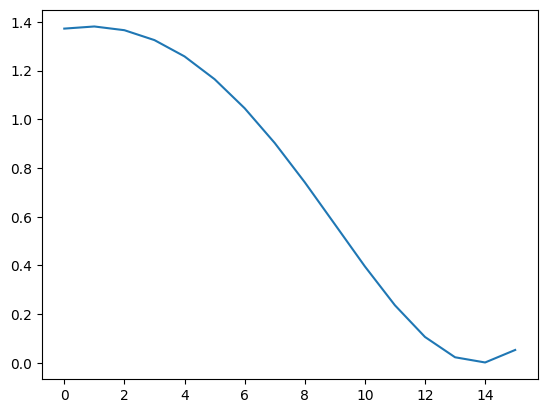

In [46]:
plt.plot(snr_range,mse)
plt.show()